In [1466]:
#%pip install pandas_datareader
#%pip install yfinance

# Prediction and Sequential Investment Strategies


## Final Assignement


### Hedging market exposure with volatility


#### Alejandro PALACIOS GARCIA              73713



##### Introduction

Througout my expirience as an investment professional I observed that one of the main problems that active investment strategies, based on long-term bets about companies' fundamentals, is the lack of proper hedging. There are several ways of hedgin market exposure and most of the investment strategies that follow the investment philosophy stated above try to hedge either partially or fully their market exposure, trying to exploit company or sector specific risk. One example of such strategies are the smart beta strategies. You can implement the hedgin of your portfolio by engagin in total return swap, by buying options, by buying futures, by shorting a market ETF or even by diversification. 

Some strategies are more expensive than others and most of them cap the both the downside risk and upside potential. If you want to do an agressive hedging, which may mean only to engage into a hedghing position when market turmoil is inminent, the cost can increase considerably due to transaction costs or margin management. I have discovered that there is one strategy that might allow to implement an agressive hedging strategy in a more efficient way. I am talking about hedging your market exposure with a volatility trade. 

Trading volatility as a hedge is very efficient as it allows to do a some sort of leverage trade. It is leverage in the sense that, when the market goes down, the volatility increase with a larger one-to-one proportion. But when the reverse happens, the proportion decreases. In that regard, hedging downside risk with a long position in volatility has a lot of sense given that, to hedge 100% of your position, you will need to buy less than 100% of the dollar notional in the volatility asset. The most efficient way to do it could be by engaging into a variance swap or buying a straddle strategy. Nonetheless, this types of trades are privative to small investors. In this project, I will explore an alternative way to implement an agressive hedging strategy in a feascible way to any investor.

Having explained the motivation behind this strategy, I will explain briefly how it works. Basically, the investor would like to predict market downturns and to hedge his portfolio by buying volatility just before a dropdown begins. This will allow the investor to only participate in the gains on a portfolio that, in this case, will be long 100% in the S&P500. We propose buying the volatility index VIXY as a proxy for volatility. As we will see, the proportion to hedge and the correlation between the S&P500 and the VIXY varies largely through time. This posses a big problem as the investors faces two big questions. One is when to hedge and the second one is how mucho does he need to buy to do it. We will implement Machine Learning methods to try to solve both questions. Then we will back test the strategy to see how it performs. 

To know when to engage in a hedging position we will use a Support Vector Machines to try to predict the market direction one day a head. We will compare this method with a trading strategy based on Moving Aveages. To know how how much you need to implement the hedge, we will predict both the S&P500 and VIXY returns one period ahead based on a combination of diferent indices and market indicators. We will use an Artificial Neural Network to do so. Then we will compute the hedgin ratio based on the forecasted returns and trade that proportion on the VIXY. This will become clearer as we implement the strategy. 

The first step will be to choose the features we will use to predict market performance and market volatility. The choice behind the features is purely based on market sentiment, even if there exist an economic rationale behind it, and realtions between assets that we have observed through time. The assets that we will be choosing are the following:

- DAX -> It is a dollar index that is built on the foreing exchange rate against a basket of representative currecies. It is very useful to assess market risk appetite given that when risk increases sharply in the market there is a flight-to-quality effect that involves buying a lot of US dollar-denominated assets, like Treasuries Bonds, which tend to push up the dollar. 

- XAU -> It is a gold price index. Similarly to what we described above, other effect that tends to happen when risk increase is a transition from risky position to gold as it is looked as a safe heaven.

- CL=F -> It is a oil price index based on oil futures. Some major market risk are related to either inflation or can have an impact in the global supply chain. This tends to have some impact in oil markets. At the same time, in recent years, some of the volatility in the markets have come from the oil market given the relation explained above.

- S&P500 -> This is the US market theoretical index. It should behave exactly the same as the market index, nonetheless, given daily trading differences that are specific to the ETF, there might be some differences between them. 
 
- DJIA -> Down Jones index. It is a more selective US market index which is largely affected by tech companies, which also account for a big proportion of the S&P500. Some contagion effect coming from specific indistries whithin the Dow Jones index can be spotted first by looking at this index. 
 
- T10YIE -> It is the 10 year Break Even inflation rate. This is an imporant measure as it allows to see the long term economic perspective that investors have. Normally, when this indicator goes up, an inminent shift to a more dovish stance from the FED members can be expected. This will mean a probable interest rate increase and, therefore, a negative performance in the equities market.
 
- T5YIFR -> This is the 5 year inflation expectation. It allows to assess medium term economic perfromance expectations. It tends to move more than the previous indicator but tends to have less predictive power about important market moves, although is good to predict more timely market tendency changes.
 
- VIXCLS -> This is the VIX theoretical index. Eventhough the VIXY ETF does a good job in following the theoretical index it is not always the case. Therefore, differences between the theoretical index and the market index could have some information embedded.
 
- DGS10 -> Is the 10 year constant Treasury yield. This is a very good indicator of economy prespective and has been show to be more reactive to market pressure than equities. There are also some effects that generate at the Monetary Policy level that are shown first in the fixed income market.
- GVZCLS -> It is a gold volatility index. As it reacts somehow similarily to the VIXY, we suspect some relation can be extracted from it. 

Now that we have been through all the hypothesis behing our strategy, lets proceed with its construction. The next step will be to obtain our data. We have chosen to base our model using the last 5 years of data available. We will obtain our data from Yahoo finance, in the case of market indexes, and from the St Louis Fed economic data base, for the rest of the indicators.


#### Data visualization and explanatory analysis

In [1587]:
# Load libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.preprocessing import StandardScaler

# Data import
import yfinance as yf
import pandas_datareader.data as web
import datetime

In [1468]:


# 5 year period
start = datetime.datetime(2017, 3, 11)
start_corr = datetime.datetime(2016, 3, 11)
end = datetime.datetime(2022, 3, 11)

idx_tickers_1 = ['^GSPC', 'VIXY','^GDAXI','^XAU','CL=F']
idx_tickers_2 = ['SP500', 'DJIA']
econ_indicators = ['T10YIE','T5YIFR','VIXCLS','DGS10','GVZCLS']

# Data obtention
etf_data = web.DataReader(idx_tickers_1, 'yahoo', start = start, end = end)
idx_data = web.DataReader(idx_tickers_2, 'fred', start = start, end = end)
econ_data = web.DataReader(econ_indicators, 'fred', start = start, end = end)
corr_data = web.DataReader(idx_tickers_1[0:2], 'yahoo', start = start, end = end)

# Rename columns for easier readability
etf_data.columns.set_levels(['S&P500','VIXY','DAX','GOLD','OIL FUT'],level=1,inplace=True)
corr_data.columns.set_levels(['S&P500','VIXY','DAX','GOLD','OIL FUT'],level=1,inplace=True)
econ_data.columns = ['10Y BE Infl','5Y Infl Exp', 'VIX Index','10Y Treasury Y','Gold Vol']
econ_col = econ_data.columns

C:\Users\apala\AppData\Local\Temp/ipykernel_15296/2903556466.py:17: FutureWarning: inplace is deprecated and will be removed in a future version.
  etf_data.columns.set_levels(['S&P500','VIXY','DAX','GOLD','OIL FUT'],level=1,inplace=True)
C:\Users\apala\AppData\Local\Temp/ipykernel_15296/2903556466.py:18: FutureWarning: inplace is deprecated and will be removed in a future version.
  corr_data.columns.set_levels(['S&P500','VIXY','DAX','GOLD','OIL FUT'],level=1,inplace=True)


Let us do a premiliminary analysis of the data we have just obtained.

In [1469]:
etf_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1291 entries, 2017-03-13 to 2022-03-11
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, S&P500)   1260 non-null   float64
 1   (Adj Close, VIXY)     1260 non-null   float64
 2   (Adj Close, DAX)      1263 non-null   float64
 3   (Adj Close, GOLD)     1260 non-null   float64
 4   (Adj Close, OIL FUT)  1261 non-null   float64
 5   (Close, S&P500)       1260 non-null   float64
 6   (Close, VIXY)         1260 non-null   float64
 7   (Close, DAX)          1263 non-null   float64
 8   (Close, GOLD)         1260 non-null   float64
 9   (Close, OIL FUT)      1261 non-null   float64
 10  (High, S&P500)        1260 non-null   float64
 11  (High, VIXY)          1260 non-null   float64
 12  (High, DAX)           1263 non-null   float64
 13  (High, GOLD)          1260 non-null   float64
 14  (High, OIL FUT)       1261 non-null   float64
 15  (Lo

<AxesSubplot:xlabel='Date'>

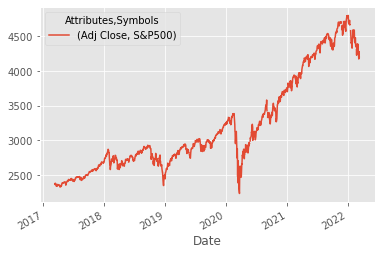

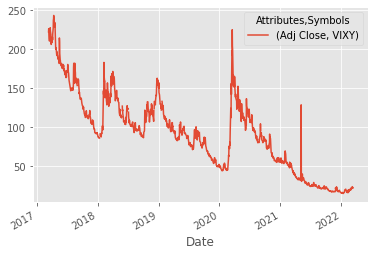

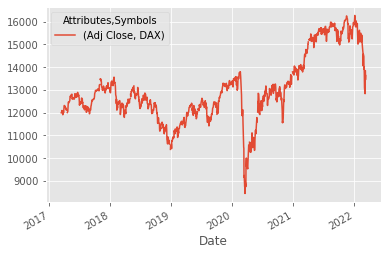

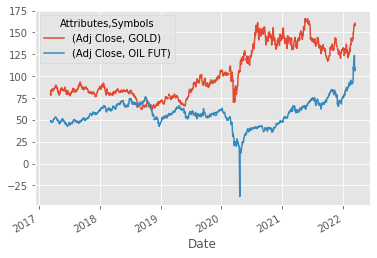

In [1588]:
etf_data_col = etf_data.columns
etf_data[etf_data_col[[0]]].plot()
etf_data[etf_data_col[[1]]].plot()
etf_data[etf_data_col[[2]]].plot()
etf_data[etf_data_col[[3,4]]].plot()

The first thing that we should notice is that the DAX and the S&P500 show a very similar behavior, while the VIXY seems to behaive in the exact opposite way. So far, this validate the rationale for choosing the VIXY as our hedging instrument and the DAX as a predictive variable. The Gold and Oil index does not seem to have a strong relation with the other indexes but the seem to be quite correlated between them.

In [1471]:
idx_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2017-03-13 to 2022-03-11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   1260 non-null   float64
 1   DJIA    1260 non-null   float64
dtypes: float64(2)
memory usage: 30.6 KB


<AxesSubplot:xlabel='DATE'>

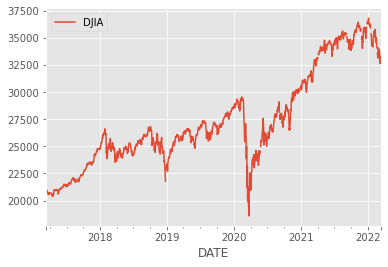

In [1589]:
idx_data['DJIA'].plot(legend='DJIA')

The Dow Jonson has a very similar behavior to both the S&P500 and the DAX. This validates our choice to choose it as an predictive variable so far.

In [1473]:
econ_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2017-03-13 to 2022-03-11
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   10Y BE Infl     1252 non-null   float64
 1   5Y Infl Exp     1252 non-null   float64
 2   VIX Index       1260 non-null   float64
 3   10Y Treasury Y  1252 non-null   float64
 4   Gold Vol        1262 non-null   float64
dtypes: float64(5)
memory usage: 61.2 KB


<AxesSubplot:xlabel='DATE'>

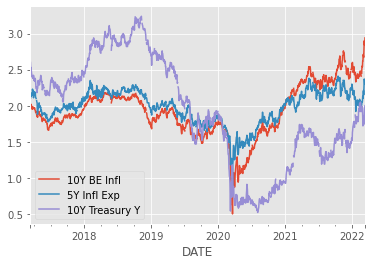

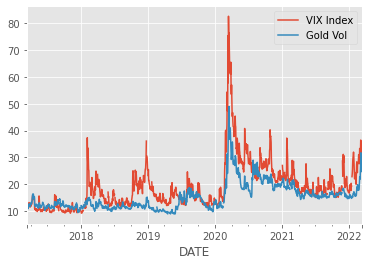

In [1590]:
econ_data[econ_col[[0,1,3]]].plot()
econ_data[econ_col[[2, 4]]].plot()

Interestingly, we can see a high correlation between the 10 year breakeven inflation, the 5 year inflation expectation, and the 10 year Treasury yield. This is not surprising given the relation we explained at the introduction. We hope that our model will be able to discover strong relation between this features and the labels on our models, which will be the S&P500 and the VIXY. 

Another interesting thing is how the VIXY and the VIX do not have the same graph at all. This makes sense as the VIX shows only the volatility evolution but the VIXY as being an investable asset has a price that evolves with the volatility evolution. We could think as if the VIX was the return plot from the VIXY. If we give a thought here we can start to understand why the VIXY seems to be a leverage investment. The volatility can be thought as being in returns measures, so you are trading directly returns not prices. This is one side of the story, another side comes from how the VIXY is actually construt. Every index is built with investable assets, so in order to replicate volatility, you need to engage in some leverage to reach the desired exposition.

Next, we will prepare and separe our data set in order to be able to pass the information to our models. In this case, we will not be tyring to predict prices but returns. Which can be though to be equivalent, but returns have a more stable distribution, which we hope could help us to better catch the relationship between assets. So, with the code below we will compute the assets' returns. We will be shifting our lables returns one day behind. This is to avoid a look ahead bias. The shift one day behind means that with information available today, we will try to predict tomorrow's return.

In [1475]:
return_period = 1

# First, we compute the returns for the S&P500 and the VIXY calling the price timeseries from the mutli index matrix and shiftin it one step back
Y = np.log(etf_data.loc[:, ('Adj Close', ('S&P500','VIXY'))]).diff(return_period).shift(-1)
# Then, we compute the returns for the rest of the indexes
X1 = np.log(etf_data.loc[:, ('Adj Close', ('DAX','GOLD','OIL FUT'))]).diff(return_period)
# We remove the multi index level to have a regular dataframe
Y.columns = Y.columns.droplevel()
X1.columns = X1.columns.droplevel()
# We compute the returns for both the economic indicators and the theoretical indexes 
X2 = np.log(econ_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)
# Finally, we form a matrix containing the S&P500 lag returns. The lag period is a multiple of the holding period specified above
X4 = pd.concat([np.log(etf_data.loc[:, ('Adj Close', 'S&P500')]).diff(i)
                for i in [return_period*3, \
                          return_period*5]], axis=1).dropna()
# We rename the columns for the lagged returns matrix
X4.columns = ['S&P500_RET_3D', 'S&P500_RET_5D']
# We do the same for the VIXY
X5 = pd.concat([np.log(etf_data.loc[:, ('Adj Close', 'VIXY')]).diff(i)
                for i in [return_period*3, \
                          return_period*5]], axis=1).dropna()
# We rename the columns for the lagged returns matrix
X5.columns = ['VIXY_RET_3D', 'VIXY_RET_5D']

# Finally, we merge all the dataframes to form our features space
X = pd.concat([Y,X1, X2, X3, X4,X5], join = "inner", axis=1).dropna()

X.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1056 entries, 2017-03-20 to 2022-03-10
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   S&P500          1056 non-null   float64
 1   VIXY            1056 non-null   float64
 2   DAX             1056 non-null   float64
 3   GOLD            1056 non-null   float64
 4   OIL FUT         1056 non-null   float64
 5   10Y BE Infl     1056 non-null   float64
 6   5Y Infl Exp     1056 non-null   float64
 7   VIX Index       1056 non-null   float64
 8   10Y Treasury Y  1056 non-null   float64
 9   Gold Vol        1056 non-null   float64
 10  SP500           1056 non-null   float64
 11  DJIA            1056 non-null   float64
 12  S&P500_RET_3D   1056 non-null   float64
 13  S&P500_RET_5D   1056 non-null   float64
 14  VIXY_RET_3D     1056 non-null   float64
 15  VIXY_RET_5D     1056 non-null   float64
dtypes: float64(16)
memory usage: 140.2 KB


In [1476]:
X

,S&P500,VIXY,DAX,GOLD,OIL FUT,10Y BE Infl,5Y Infl Exp,VIX Index,10Y Treasury Y,Gold Vol,SP500,DJIA,S&P500_RET_3D,S&P500_RET_5D,VIXY_RET_3D,VIXY_RET_5D
2017-03-20,-0.012486,0.039484,-0.003507,0.012280,-0.011546,-0.004988,0.004684,0.005305,-0.012073,0.049672,-0.002012,-0.000419,-0.004955,0.000000,-0.032888,-0.054707
2017-03-21,0.001888,0.005100,-0.007560,0.013785,-0.018418,-0.010050,0.009302,0.094989,-0.016327,0.066464,-0.012486,-0.011442,-0.015813,-0.009101,0.025899,-0.033049
2017-03-22,-0.001061,0.033587,-0.004861,0.004357,0.014678,-0.005063,-0.004640,0.026900,-0.012423,0.012290,0.001888,-0.000325,-0.012609,-0.015553,0.042307,0.011696
2017-03-23,-0.000844,-0.018440,0.011323,-0.007549,-0.007103,-0.010204,0.000000,0.023912,0.004158,0.024136,-0.001061,-0.000228,-0.011658,-0.014985,0.078170,0.064585
2017-03-24,-0.001020,-0.020247,0.002040,-0.005580,0.005644,0.015267,0.036534,-0.012270,-0.004158,-0.042214,-0.000844,-0.002902,-0.000017,-0.014515,0.020247,0.057453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04,-0.029963,0.084823,-0.045084,0.031913,0.071757,-0.007463,-0.027525,0.048040,-0.066691,0.136307,-0.007966,-0.005336,0.005237,-0.012803,-0.019022,0.131459
2022-03-07,-0.007260,-0.009946,-0.020047,0.016630,0.031651,0.036769,0.045462,0.130831,0.022728,0.120948,-0.029963,-0.024008,-0.043197,-0.040320,0.130340,0.167798
2022-03-08,0.025374,-0.041710,-0.000245,0.009030,0.035380,0.045863,0.051960,-0.036886,0.043963,0.066180,-0.007260,-0.005645,-0.045188,-0.031986,0.115504,0.055855
2022-03-09,-0.004301,-0.044472,0.076232,-0.009728,-0.129267,-0.020907,-0.008475,-0.079355,0.042111,-0.123755,0.025374,0.019831,-0.011849,-0.025083,0.033167,0.078684


array([[<AxesSubplot:title={'center':'S&P500'}>,
        <AxesSubplot:title={'center':'VIXY'}>,
        <AxesSubplot:title={'center':'DAX'}>,
        <AxesSubplot:title={'center':'GOLD'}>],
       [<AxesSubplot:title={'center':'OIL FUT'}>,
        <AxesSubplot:title={'center':'10Y BE Infl'}>,
        <AxesSubplot:title={'center':'5Y Infl Exp'}>,
        <AxesSubplot:title={'center':'VIX Index'}>],
       [<AxesSubplot:title={'center':'10Y Treasury Y'}>,
        <AxesSubplot:title={'center':'Gold Vol'}>,
        <AxesSubplot:title={'center':'SP500'}>,
        <AxesSubplot:title={'center':'DJIA'}>],
       [<AxesSubplot:title={'center':'S&P500_RET_3D'}>,
        <AxesSubplot:title={'center':'S&P500_RET_5D'}>,
        <AxesSubplot:title={'center':'VIXY_RET_3D'}>,
        <AxesSubplot:title={'center':'VIXY_RET_5D'}>]], dtype=object)

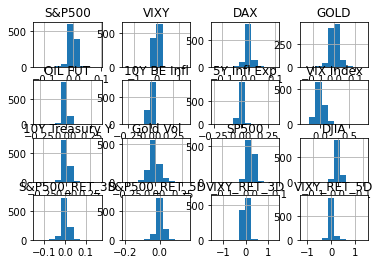

In [1477]:
X.hist()

Here, we can see that all the returns are centered around cero, which is what we would expect from a return distribution but the VIX index show some important positive skewness. But that series is not in returns terms as it is the percentual change in volatility, which can be though as a second order return.

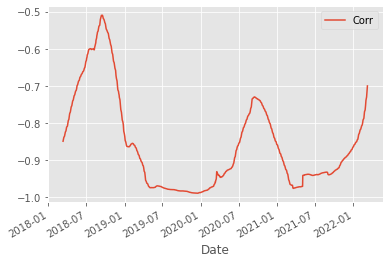

In [1591]:
# Here, we call our labels returns
X_corr=corr_data.loc[:, ('Adj Close', ('S&P500','VIXY'))]
# We drop the multilevel index
X_corr.columns = X_corr.columns.droplevel()
# Here, we compute the correlation between our two labels
X_corr = pd.DataFrame(X_corr['S&P500'].rolling(252).corr(X_corr['VIXY'])).dropna()
X_corr.columns=['Corr']
X_corr.plot(label='Correlation')
plt.legend()

As part of the explanatory analysis, we have also computed the rolling correlation between the S&P500 and the VIXY returns. As we can see, the correlation varies a lot between -0.5 and -1 but it is always negative, which, again, validates our choice to choose the VIXY as our hedging asset. From here, it is reasonable to think that 0.5 should be a lower bound to our hedge ratio. It is important to mention that you would like to stablish a lower bond because if the predicted proportion to hedge is lower, as we would be performing an agressive hedging, you may want to overhedge when you dont need to invest that much to perform your hedging. In other words, it is easy to overhedge when you need to invest only 20% of the original position than when you need the 100%.

In [1479]:
# We merge all dataframes so we can standardize the index to all our time series
dataset = pd.concat([X,X_corr], join = "inner", axis=1).dropna()
dataset

,S&P500,VIXY,DAX,GOLD,OIL FUT,10Y BE Infl,5Y Infl Exp,VIX Index,10Y Treasury Y,Gold Vol,SP500,DJIA,S&P500_RET_3D,S&P500_RET_5D,VIXY_RET_3D,VIXY_RET_5D,Corr
2018-03-12,-0.006384,0.021293,0.005791,0.009712,-0.011021,-0.009479,-0.044851,0.074986,-0.010399,0.006378,-0.001275,-0.006221,0.020408,0.022559,-0.079786,-0.083697,-0.848909
2018-03-13,-0.005741,0.019686,-0.016020,0.000376,-0.010650,-0.004773,-0.023203,0.035485,-0.010508,-0.028560,-0.006384,-0.006838,0.009571,0.013540,-0.020559,-0.069902,-0.845812
2018-03-14,-0.000782,-0.031326,0.001366,0.001129,0.004109,-0.009615,-0.014185,0.052424,-0.010620,-0.027477,-0.005741,-0.010003,-0.013400,0.008283,0.081814,-0.038807,-0.842811
2018-03-15,0.001702,-0.016344,0.008772,-0.012358,0.003766,0.004819,-0.004773,-0.037852,0.003552,-0.000961,-0.000782,0.004656,-0.012907,0.003048,0.009653,-0.032199,-0.840555
2018-03-16,-0.014306,0.088993,0.003559,-0.001397,0.018620,0.000000,0.009524,-0.048790,0.010582,-0.051293,0.001702,0.002925,-0.004821,-0.012480,-0.027984,0.034144,-0.838235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04,-0.029963,0.084823,-0.045084,0.031913,0.071757,-0.007463,-0.027525,0.048040,-0.066691,0.136307,-0.007966,-0.005336,0.005237,-0.012803,-0.019022,0.131459,-0.738657
2022-03-07,-0.007260,-0.009946,-0.020047,0.016630,0.031651,0.036769,0.045462,0.130831,0.022728,0.120948,-0.029963,-0.024008,-0.043197,-0.040320,0.130340,0.167798,-0.730057
2022-03-08,0.025374,-0.041710,-0.000245,0.009030,0.035380,0.045863,0.051960,-0.036886,0.043963,0.066180,-0.007260,-0.005645,-0.045188,-0.031986,0.115504,0.055855,-0.721843
2022-03-09,-0.004301,-0.044472,0.076232,-0.009728,-0.129267,-0.020907,-0.008475,-0.079355,0.042111,-0.123755,0.025374,0.019831,-0.011849,-0.025083,0.033167,0.078684,-0.714825


<AxesSubplot:title={'center':'Correlation Matrix'}>

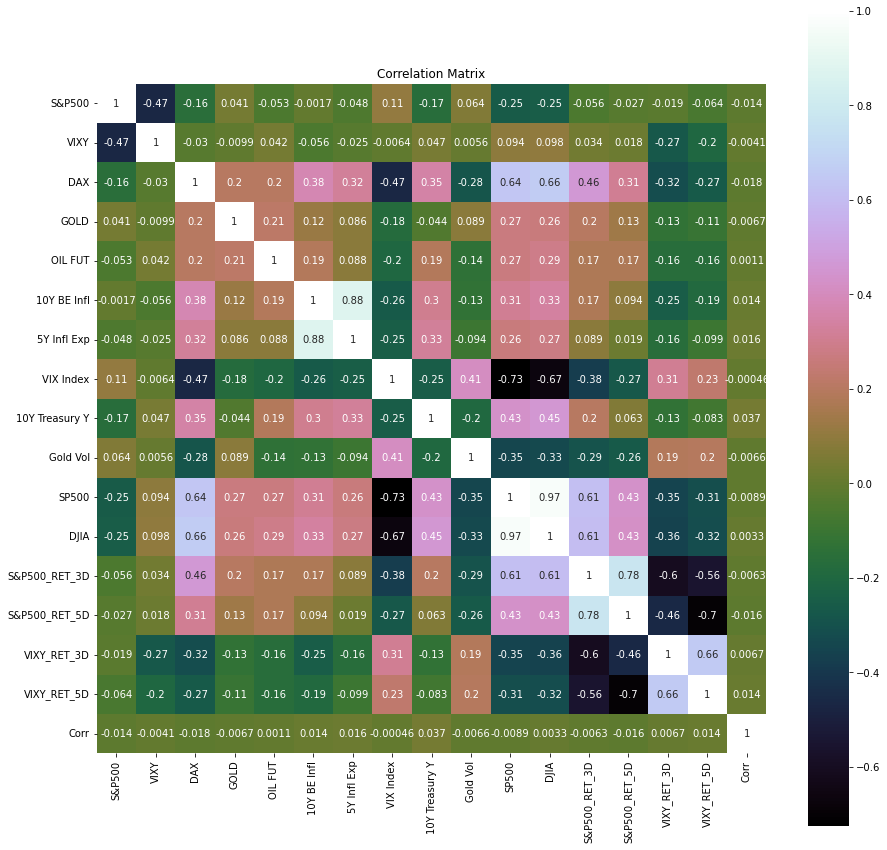

In [1480]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Another important thing to see as a part of an explanatory analysis is how correlated are the features with our labels and between them. Ideally, we want explanatory variables that are somewhat correlated with the lables but not hihgly correlated as then, the independent variable can simply be expressed as a linear combination of the highly correlated feature. In this case, we can a spot a problem of high correlation between the S&P500 and the DJIA. Nonetheless, when you compare it with the lag returns of the S&P500 the correlation not only decreases sharply, it even goes negative to 0.25. It seems that none of our variables have a stong predictive power regardint VIXY and S&P500 returns. We will see how well our Machine Learnging methods overcome this. 

Now, we will start constructing our model to predict our label returns. We will do first the S&P500 returns. This will be done through an Artificial Neural Network model that we will define next.

#### Stock return prediction using ANN

In [1481]:
#%pip install tensorflow

# Sci-kit learning methods for machine learning download
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
# Error Metrics
from sklearn.metrics import mean_squared_error

# keras methods for machine learning download
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Data split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [1482]:
# We recover our data from the dataser
Y_1=dataset['S&P500'].copy()
Y_2=dataset['VIXY'].copy()
X_corr=X.iloc[:,-1]
X=dataset.copy()
X.drop(['S&P500','VIXY','Corr'], inplace=True, axis=1)


In [1483]:
# Here we will look for the features with highest explanatory power regarding the S&P500
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(dataset.iloc[:,2:-1],Y_1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # Naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #Print 10 best features

,Score
Specs,
SP500,58.441723
DJIA,55.982664
10Y Treasury Y,23.845052
DAX,20.962413
VIX Index,9.872759
VIXY_RET_5D,3.520162
Gold Vol,3.491950
S&P500_RET_3D,2.627770
OIL FUT,2.377324


Quite interestingly, the S&P500 and DJIA showed the strongest explanatory power to predict the next day S&P500 return even though in the correlation matrix we would could have suspected the contrary.

In [1484]:
# Here we will look for the features with highest explanatory power regarding the VIXY
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(dataset.iloc[:,2:-1],Y_2)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # Naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  # Print 10 best features

,Score
Specs,
VIXY_RET_3D,66.091517
VIXY_RET_5D,36.218441
DJIA,8.205273
SP500,7.540404
10Y BE Infl,2.619041
10Y Treasury Y,1.881268
OIL FUT,1.522329
S&P500_RET_3D,0.972022
DAX,0.786725


Regarding the VIXY, we can see that the lagged returns of the VIXY have strong explanatory power. This is somewhat expected given that the volatility tend to show clusters through time. This analysis has showed us that some of our rationales regarding our feature preparation was correct and we are all reading adding some new information like in the case of the lagged returns. We will now separe our data into a train and test set in order to train our model.

In [1485]:
validation_size = 0.10
# As we are analyzing a time series, the split between train and test set has to be continous to preserve data order
train_size = int(len(X) * (1-validation_size))
x_train_1, x_test_1 = X[0:train_size], X[train_size:len(X)]
y_train_1, y_test_1 = Y_1[0:train_size], Y_1[train_size:len(X)]

Before diving direclty into our ANN, we will test other ML methods to see if there is another option that clearly outperfors a Multi-layer Precepton model. We will be looking at the following models:

- Linear Regression
- LASSO -> Regularized Linear Regression
- K-Nearest Neighbors
- Multi-Layer Precepton
- AdaBoost Regressor
- Random Forest Regressor


In [1486]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(100,100))))
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))

In [1487]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error' 
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## Here, we perform the K-Fold analysis:
    kfold = KFold(n_splits=num_folds)
    # We convert the mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, x_train_1, y_train_1, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Now, we perform the full training period
    res = model.fit(x_train_1, y_train_1)
    train_result = mean_squared_error(res.predict(x_train_1), y_train_1)
    train_results.append(train_result)
    
    # Finally, we compute the test results
    test_result = mean_squared_error(res.predict(x_test_1), y_test_1)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000215 (0.000316) 0.000169 0.000164
LASSO: 0.000203 (0.000345) 0.000202 0.000117
KNN: 0.000222 (0.000362) 0.000147 0.000134
MLP: 0.000288 (0.000450) 0.000186 0.000162
ABR: 0.000210 (0.000327) 0.000119 0.000140
RFR: 0.000224 (0.000366) 0.000032 0.000128


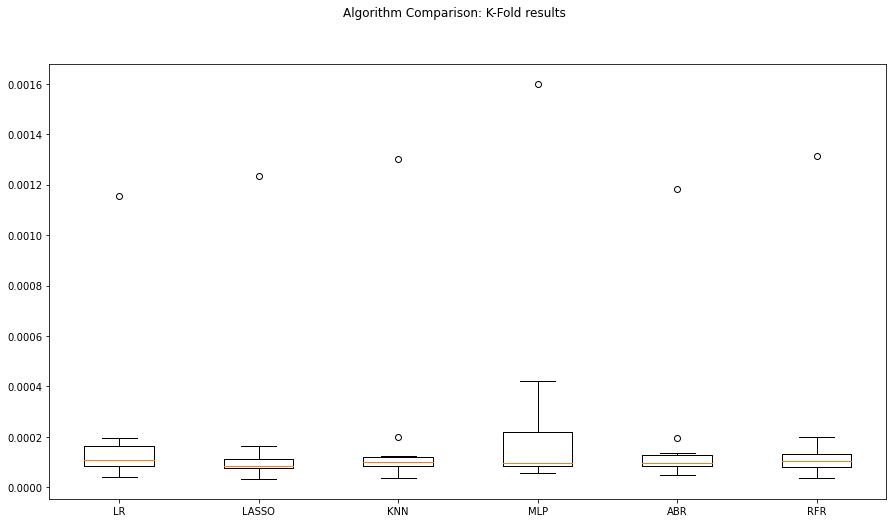

In [1488]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: K-Fold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

Given the presence of outliers in our error metrics, it is hard to implement the box plot. Although we can see that all models perform similarly, the KNN models seems to be the most consistent model. Nonetheless, it is importat to see if it si not over fitting the training sample. We will need to look also at the validation error.

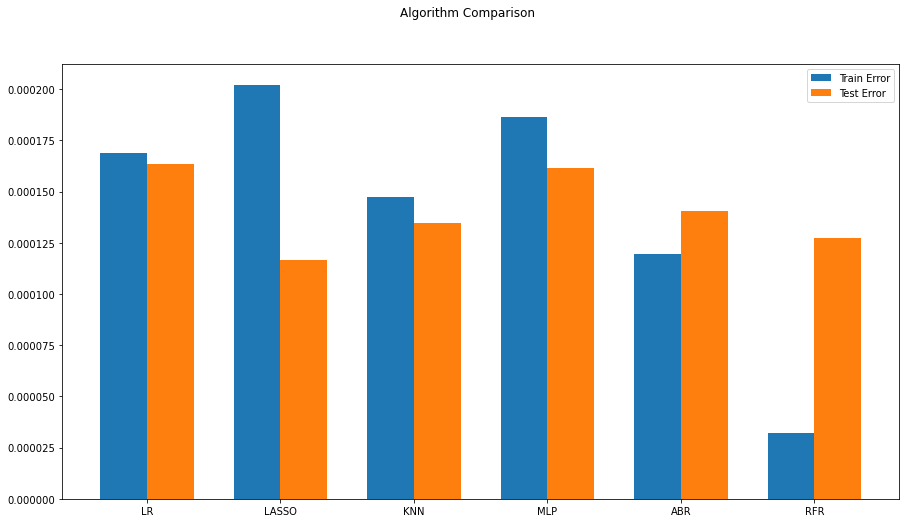

In [1489]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Here, we can see clearly that the Rainforest Regressor was overfitting the training set. In therms of test error, the best models are LASSO, KNN and the MLP. We are interested in see how the ANN will perform, we have seen here that its perfromance is not very far from the best performing model. We will try to fit the ANN using different hyperparameters to see how well we can predit our asset returns. Next, let us construct our ANN architecture.

In [1490]:
# Here, we define the learning rate to be implemented in the Stochastic Gradient Descent method
learning_rate=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Here, we created a function to build and ANN for a given number of layers and nodes
def train_model(hidden_layers, nodes, optimizer=optimizer):
    model = Sequential()
    
    
    model.add(Input(shape=x_train_1.shape[1:])) # Here, is important to define the input shape

    for x in range(0, hidden_layers):
        model.add(Dense(nodes, activation='tanh')) # We use 'tanh' activation function given that is symmetric around 0
        
    model.add(Dense(1)) # the final layer doesn't need no activation function since this is a linear regression model

    model.compile(loss='mean_squared_error', optimizer = optimizer) # We use MSE as loss function since this is a linear regression model
    
    return model

In [1491]:
train_model(hidden_layers=5, nodes=100).summary()

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_411 (Dense)           (None, 100)               1500      
                                                                 
 dense_412 (Dense)           (None, 100)               10100     
                                                                 
 dense_413 (Dense)           (None, 100)               10100     
                                                                 
 dense_414 (Dense)           (None, 100)               10100     
                                                                 
 dense_415 (Dense)           (None, 100)               10100     
                                                                 
 dense_416 (Dense)           (None, 1)                 101       
                                                                 
Total params: 42,001
Trainable params: 42,001
Non-tra

This is our ANN architecture, now let us train the model

In [1492]:
g_1 = train_model(hidden_layers=4, nodes=100).fit(x_train_1, y_train_1, epochs=100, batch_size=50, validation_data=(x_test_1, y_test_1))

Epoch 1/100
16/16 [==============================] - 2s 25ms/step - loss: 0.0018 - val_loss: 6.6097e-04
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 5.0148e-04 - val_loss: 1.6331e-04
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 2.8514e-04 - val_loss: 2.3995e-04
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 2.4992e-04 - val_loss: 1.5882e-04
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 2.3702e-04 - val_loss: 1.7109e-04
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 2.2136e-04 - val_loss: 1.6023e-04
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 1.9241e-04 - val_loss: 1.7313e-04
Epoch 8/100
16/16 [==============================] - 0s 6ms/step - loss: 2.1264e-04 - val_loss: 1.5141e-04
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 2.1322e-04 - val_loss: 1.6169e-04
Epoch 10/100
16/16 [====================

In [1493]:
final_loss_adam = g_1.history['loss'][-1]
final_val_loss_adam = g_1.history['val_loss'][-1]
final_val_loss_adam

0.00015728612197563052

The test MSE is only 0.016% which sounds small, but we need to recall that we are working with returns so this error can be relevant. Let us explore more deeply the errors evolution.

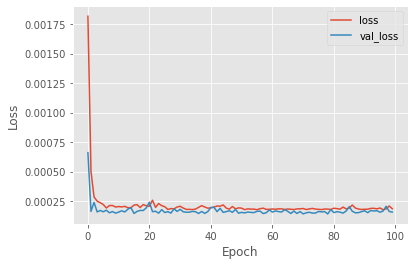

In [1592]:
plt.plot(g_1.history['loss'], label='loss')
plt.plot(g_1.history['val_loss'], label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The training error decreases sharply as it should and then both the test and the train set MSE are quite consistent. But again, the scale of the data can be misleading. Let us see how the actual returns look against our predictions.

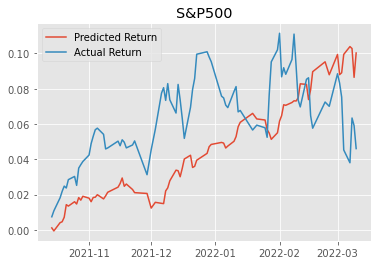

In [1593]:
predictions_1 = g_1.model.predict(x_test_1)
plt.plot(pd.DataFrame(predictions_1,index=y_test_1.index).cumsum(),label='Predicted Return')
plt.plot(pd.DataFrame(y_test_1).cumsum(), label='Actual Return')
plt.title('S&P500')
plt.legend()
plt.show()

On this graph we can see that at the begining the prediction was at least going on the same direction, but at some point the prediction started to behave very poorly. This is understandable as we have a fixed window for training but the relationship betwee assets change dialy, it is never constant. So, it would be better to have very small predicting window and each day incorporating the new information. Let us look now how the ANN performs in predicing VIXY returns. We will perform the same analysis, we will tryout other models than the ANN and see their perfromance.

In [1496]:
validation_size = 0.10
# As we are analyzing a time series, the split between train and test set has to be continous to preserve data ordertrain_size = int(len(X) * (1-validation_size))
train_size = int(len(X) * (1-validation_size))
x_train_2, x_test_2 = X[0:train_size], X[train_size:len(X)]
y_train_2, y_test_2 = Y_2[0:train_size], Y_2[train_size:len(X)]

In [1497]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error' 
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## Here, we perform the K-Fold analysis:
    kfold = KFold(n_splits=num_folds)
    # We convert the mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, x_train_2, y_train_2, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Now, we perform the full training period
    res = model.fit(x_train_2, y_train_2)
    train_result = mean_squared_error(res.predict(x_train_2), y_train_2)
    train_results.append(train_result)
    
    # Finally, we compute the test results
    test_result = mean_squared_error(res.predict(x_test_2), y_test_2)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.008222 (0.015110) 0.005839 0.002585
LASSO: 0.007317 (0.015067) 0.007288 0.002258
KNN: 0.008434 (0.014783) 0.005420 0.003381
MLP: 0.008567 (0.016087) 0.004463 0.002410
ABR: 0.010443 (0.016282) 0.002054 0.002348
RFR: 0.009025 (0.015298) 0.001302 0.002692


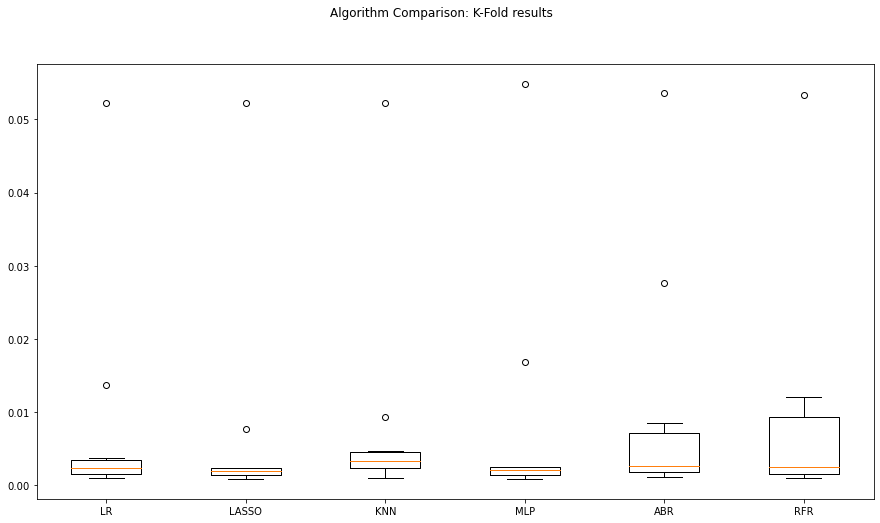

In [1498]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: K-Fold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

Here, we can start noticing that even though the MSE are larger that in the previous case, the boxes look smaller and this is becase the outlayers are even further. So, we can start expecting a poorer fit already.

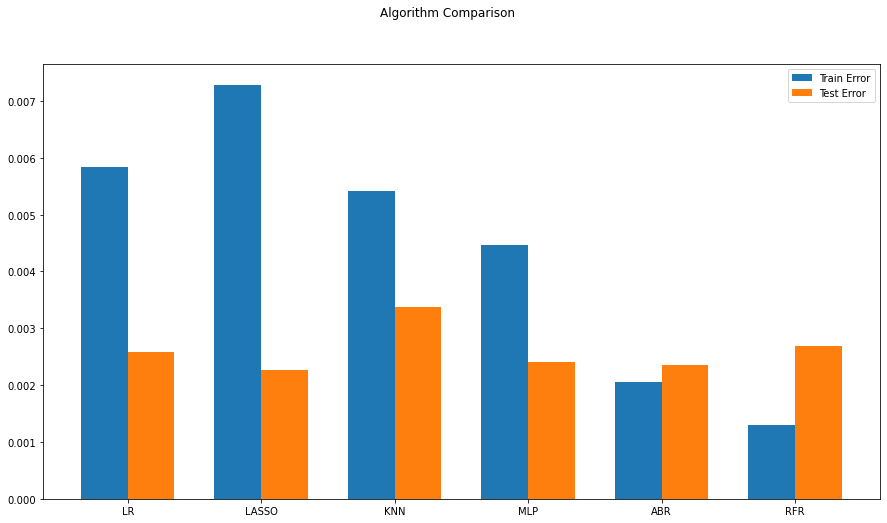

In [1499]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

This time, only LASSO and the MLP seem to be behaving similarly on way betther than the other models. Once again, the RFR was overfitting the training set. Let construct another ANN to model the VIXY returns.

In [1500]:
learning_rate=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train_model(hidden_layers, nodes, optimizer=optimizer):
    model = Sequential()
    
    
    model.add(Input(shape=x_train_2.shape[1:])) # We need to specify the input shape

    for x in range(0, hidden_layers):
        model.add(Dense(nodes, activation='tanh')) # We use 'tanh' function as it is symmetric around zero 
        
    model.add(Dense(1)) # the final layer doesn't need no activation function since this is a linear regression model

    model.compile(loss='mean_squared_error', optimizer = optimizer) # We use MSE as loss function since this is a linear regression model
    
    return model

In [1501]:
train_model(hidden_layers=4, nodes=100).summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_422 (Dense)           (None, 100)               1500      
                                                                 
 dense_423 (Dense)           (None, 100)               10100     
                                                                 
 dense_424 (Dense)           (None, 100)               10100     
                                                                 
 dense_425 (Dense)           (None, 100)               10100     
                                                                 
 dense_426 (Dense)           (None, 1)                 101       
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [1502]:
g_2 = train_model(hidden_layers=4, nodes=200).fit(x_train_2, y_train_2, epochs=100, batch_size=50, validation_data=(x_test_2, y_test_2))

Epoch 1/100
16/16 [==============================] - 1s 16ms/step - loss: 0.0129 - val_loss: 0.0056
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0024
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0077 - val_loss: 0.0024
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0025
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0024
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0026
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0024
Epoch 8/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0025
Epoch 9/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0023
Epoch 10/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0025
Epoch 11

In [1503]:
final_loss_adam = g_2.history['loss'][-1]
final_val_loss_adam = g_2.history['val_loss'][-1]
final_val_loss_adam

0.00287130125798285

Now, the error has almost doubled. It is now 0.29%. This is not a good sing. Let see how the error evolved this time.

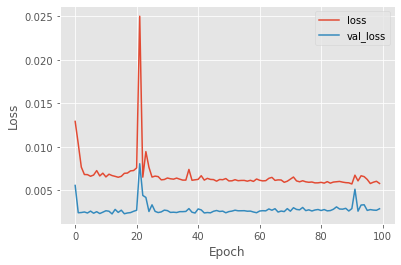

In [1594]:
plt.plot(g_2.history['loss'], label='loss')
plt.plot(g_2.history['val_loss'], label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The train error decreases importantly but it stays always above the test MSE. This is quite concerning. We can already be sure that in this case the ANN will deliver a poor performance.

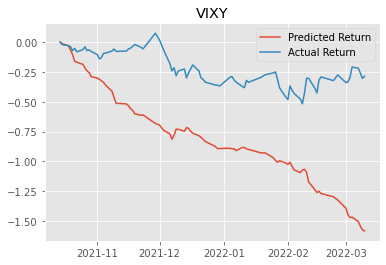

In [1595]:
predictions_2 = g_2.model.predict(x_test_2)
plt.plot(pd.DataFrame(predictions_2,index=y_test_2.index).cumsum(),label='Predicted Return')
plt.plot(pd.DataFrame(y_test_2).cumsum(), label='Actual Return')
plt.title('VIXY')
plt.legend()
plt.show()

As suspected, the fit is quite poor. It seems to be good only in the very beginning, so we has the same conclusion that before. We would need to have very short prediction window and incorporate each new day information fo this kind of models. Also, an alternative model that might be worth trying is the Recursive Neural Network as they are specialized in data in which order matters, specially those having a Long-short term memory or GRU structure as they allow the model to remember information from the past. Finally, let us look how our actual hedge ratio look against the predicted one, which will be computed using the predicted returns.

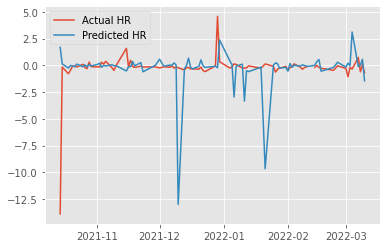

In [1596]:
hedge_ratio = pd.DataFrame(y_test_1/y_test_2)
pred_hedge_ratio = pd.DataFrame(predictions_1/predictions_2,index=hedge_ratio.index)
plt.plot(hedge_ratio, label = 'Actual HR')
plt.plot(pred_hedge_ratio,label  = 'Predicted HR')
plt.legend()

Overall, it seems that the error are not very big. Nonetheless, one should acount for the scale of the outlayers, making the analysis complex. A normal heding ratio should be between 0 and 1, here we have them going up to 5 and -13. So, this outliers doesn't allow us to fully se how different was the prediciton against the predicted. Nevertheless, there are some important differences that might be worrisome. 

Another option that could have been interesting would have been to take as a label the predicted hedge ratio and then use maybe a RNN to predicted it. But in this case we would also need to have a short prediction period and to incorporate each new day information into the model. We could have also tried to optimize the ANN hyperparamentes, i.e., the number of layers and the layers per neurons. This make saense given that the architecture for modeling the S&P500 may differ from the one needed to model the VIXY. We will see how this error in the hedge ratio impact in our final strategy. The next step will be to try to predict the market direction in order to know when to engage in to a hedging position.

In this step, we will compare a strategy based on moving averages and a supported vector machine model to see which captures better the market tendency changes. The moving average strategy is a strategy that basically send a buy order whenever the short window moving average crosses from below a big window moving average and sends a sell order in the contraty case. On the other hand a SVM model more hard to explain intuintively. We could think about it as an algorithim that plots the datapoints into a n-dimensional space, in which n is equivalent to the number of features, and then the model tries to find the optimal hyperpalne that separates the data points into to classes. In our case, we will have to classes negative return or positive return. In this regard, we are talking about a classification model. 

Let us analyze the Moving Average Performance first.

#### Simple Moving Average Strategy

Expliting a moving average strategy on the S&P500 is very difficult given that it is one of the most followed assets and, therefore, there are a several investors enganging in technical analysis withit it. A lot of people know about the strategy based on moving average described above and how it works. What is tricky sometimes is to choose what period to choose for both the short and the long horizon. The most popular choice is 30 days and 50 or 100 days respectively. We will try out this strategy and we will try to find the optimal period for each leg. We will first start with shorter periods than usual, choosing as periods 5 days and 30 days.

In [1598]:
sma1 = 5
sma2 = 30

In [1599]:
# Here, we will define a new dataframe with the S&P500 returns in order to store there the resulting MAs
df = etf_data[etf_data_col[[0]]].copy()
df.columns=df.columns.droplevel()
df.dropna(inplace=True)
# Here, we compute the moving averages for the chosen windows
df['sma_s'] = df['S&P500'].rolling(window = sma1).mean()
df['sma_l'] = df['S&P500'].rolling(window = sma2).mean()
df.dropna(inplace=True)

In [1600]:
df

Symbols,S&P500,sma_s,sma_l
Date,,,
2017-04-24,2374.149902,2351.807959,2356.986979
2017-04-25,2388.610107,2361.091992,2357.491650
2017-04-26,2387.449951,2370.947998,2358.224984
2017-04-27,2388.770020,2377.533984,2358.341984
2017-04-28,2384.199951,2384.635986,2358.435986
...,...,...,...
2022-03-07,4201.089844,4317.250000,4408.676644
2022-03-08,4170.700195,4290.138086,4400.695654
2022-03-09,4277.879883,4268.406055,4398.076644


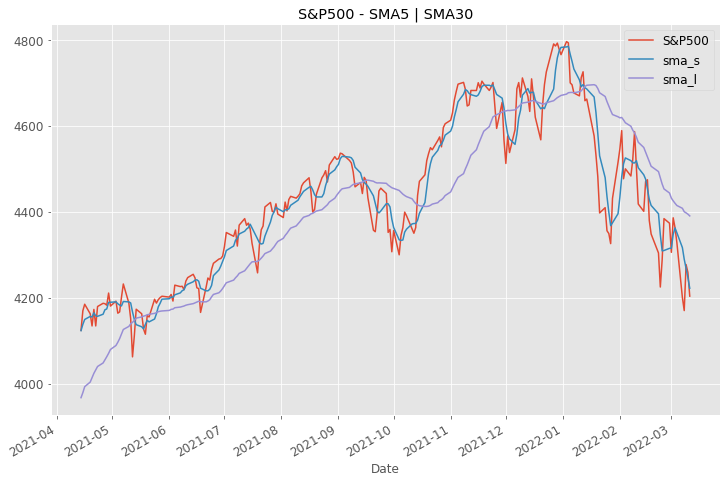

In [1601]:
df[1000:].plot(figsize = (12, 8), title = 'S&P500 - SMA{} | SMA{}'.format(sma1, sma2), fontsize = 12)
plt.legend(fontsize = 12);

He have chosen to plot only the last 231 days to facilitate the visualization of the MAs. What it is interesting to see is that even thouhg the periods are fairly short, the trade signals for a one year frame are less than 10. It is impmortant to remember that when sma_s crosses the sma_l fro above a sell signal is sent. Let see how a strategy based on such signals perform. 

In [1602]:
# Here, we create the signas. Every time the short period MAs is above the long one we go long the S&P500. We go short otherwise
df['position'] = np.where(df['sma_s'] > df['sma_l'], 1, -1)

In [1603]:
df

Symbols,S&P500,sma_s,sma_l,position
Date,,,,
2017-04-24,2374.149902,2351.807959,2356.986979,-1
2017-04-25,2388.610107,2361.091992,2357.491650,1
2017-04-26,2387.449951,2370.947998,2358.224984,1
2017-04-27,2388.770020,2377.533984,2358.341984,1
2017-04-28,2384.199951,2384.635986,2358.435986,1
...,...,...,...,...
2022-03-07,4201.089844,4317.250000,4408.676644,-1
2022-03-08,4170.700195,4290.138086,4400.695654,-1
2022-03-09,4277.879883,4268.406055,4398.076644,-1


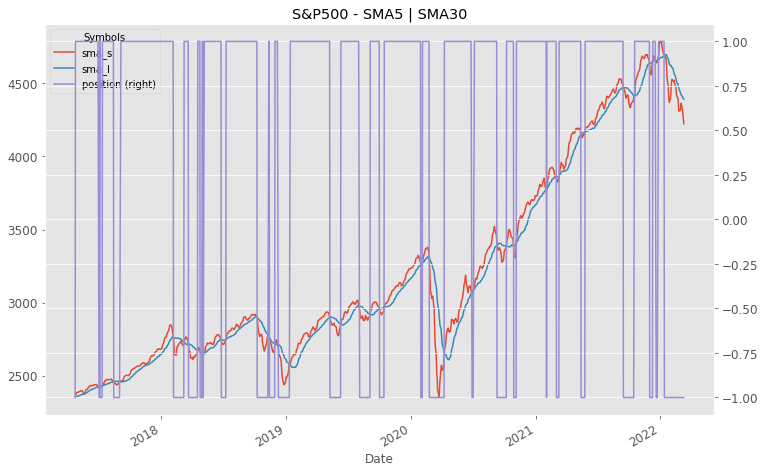

In [1604]:
df.loc[:, ['sma_s', 'sma_l', 'position']].plot(figsize = (12, 8), fontsize = 12, secondary_y = 'position', title = 'S&P500 - SMA{} | SMA{}'.format(sma1, sma2));

We can see that in a 5 year period the amount of trades is not huge for such a short periods used in the strategy. Let make a zoom to the period we shown before.

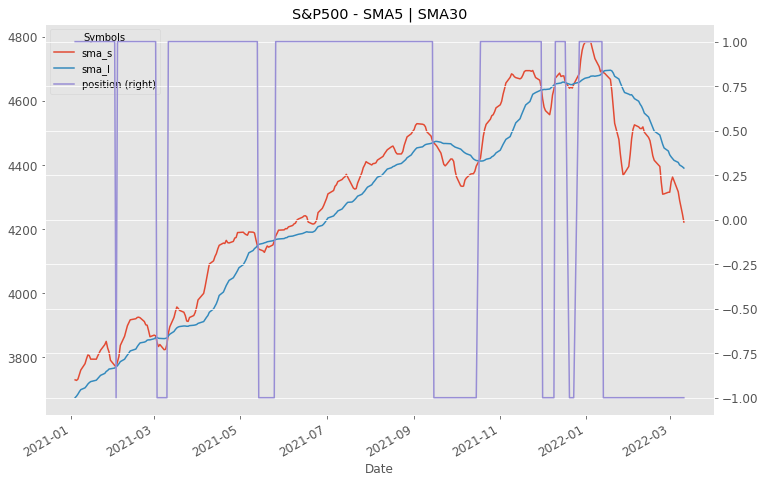

In [1605]:
df.loc['2021':, ['sma_s', 'sma_l', 'position']].plot(figsize = (12, 8), fontsize = 12, secondary_y = 'position', title = 'S&P500 - SMA{} | SMA{}'.format(sma1, sma2));

There are 13 trades here but we have added two months in the plot. Also, it seems to have a very good performance. Nonetheless, as we will see below. The porformance of this strategy is not sustainalbe as the backtesting will show that depending on the dataframe chosen, the strategy perfroms very differently.

#### Vectorized Strategy Backtesting

Here, we will perfrom a Vectorized Backtesting to see how our MAs strategy would have perforomed for different times frames. Vectorized backtesting can be applied to validate trading strategies in the following cases:

- Simple trading strategies
- Interactive strategy exploration
- Visualization as major goal
- Comprehensive backtesting programs

In this case, we will be simply testing our basic Moving Average Strategies but it will also be used further in this course work to assess the final perfromance of our final strategy. 

 We aim to show how variable the perfromance of a MA strategy can be. We believe it can work for some time, but as soon as profit is start to being made, the market will learn about it.

In [1606]:
df

Symbols,S&P500,sma_s,sma_l,position
Date,,,,
2017-04-24,2374.149902,2351.807959,2356.986979,-1
2017-04-25,2388.610107,2361.091992,2357.491650,1
2017-04-26,2387.449951,2370.947998,2358.224984,1
2017-04-27,2388.770020,2377.533984,2358.341984,1
2017-04-28,2384.199951,2384.635986,2358.435986,1
...,...,...,...,...
2022-03-07,4201.089844,4317.250000,4408.676644,-1
2022-03-08,4170.700195,4290.138086,4400.695654,-1
2022-03-09,4277.879883,4268.406055,4398.076644,-1


In [1607]:
# Let's compute the S&P500 returns and shift them one day back to avoid a look ahead bias
df['returns'] = np.log(df['S&P500'] / df['S&P500'].shift(1))
df

Symbols,S&P500,sma_s,sma_l,position,returns
Date,,,,,
2017-04-24,2374.149902,2351.807959,2356.986979,-1,NaN
2017-04-25,2388.610107,2361.091992,2357.491650,1,0.006072
2017-04-26,2387.449951,2370.947998,2358.224984,1,-0.000486
2017-04-27,2388.770020,2377.533984,2358.341984,1,0.000553
2017-04-28,2384.199951,2384.635986,2358.435986,1,-0.001915
...,...,...,...,...,...
2022-03-07,4201.089844,4317.250000,4408.676644,-1,-0.029963
2022-03-08,4170.700195,4290.138086,4400.695654,-1,-0.007260
2022-03-09,4277.879883,4268.406055,4398.076644,-1,0.025374


In [1608]:
# Now, we simulate the strategy returns. We do this by simply multiplying the singal by the return
df['strategy'] = df['position'].shift(1) * df['returns']
df.dropna(inplace = True)
df

Symbols,S&P500,sma_s,sma_l,position,returns,strategy
Date,,,,,,
2017-04-25,2388.610107,2361.091992,2357.491650,1,0.006072,-0.006072
2017-04-26,2387.449951,2370.947998,2358.224984,1,-0.000486,-0.000486
2017-04-27,2388.770020,2377.533984,2358.341984,1,0.000553,0.000553
2017-04-28,2384.199951,2384.635986,2358.435986,1,-0.001915,-0.001915
2017-05-01,2388.330078,2387.472021,2358.771989,1,0.001731,0.001731
...,...,...,...,...,...,...
2022-03-07,4201.089844,4317.250000,4408.676644,-1,-0.029963,0.029963
2022-03-08,4170.700195,4290.138086,4400.695654,-1,-0.007260,0.007260
2022-03-09,4277.879883,4268.406055,4398.076644,-1,0.025374,-0.025374


In [1609]:
# Calculates absolute performance
df[['returns', 'strategy']].sum()

Symbols
returns     0.571471
strategy    0.139719
dtype: float64

In [1610]:
# Calculates absolute performance
df[['returns', 'strategy']].sum().apply(np.exp)

Symbols
returns     1.770870
strategy    1.149951
dtype: float64

In [1611]:
# Annualized returns
df[['returns', 'strategy']].mean() * 252

Symbols
returns     0.117082
strategy    0.028625
dtype: float64

So, far we can see that the strategy strongly under perfrom the market return during the whole period, but maybe it will be a litte more insightful to see how the perfromance looks on a risk-adjusted measure.

In [1612]:
# Annualized risk
df[['returns', 'strategy']].std() * np.sqrt(252)

Symbols
returns     0.199610
strategy    0.199739
dtype: float64

In [1613]:
df['creturns'] = df['returns'].cumsum().apply(np.exp)
df['cstrategy'] = df['strategy'].cumsum().apply(np.exp)
df

Symbols,S&P500,sma_s,sma_l,position,returns,strategy,creturns,cstrategy
Date,,,,,,,,
2017-04-25,2388.610107,2361.091992,2357.491650,1,0.006072,-0.006072,1.006091,0.993946
2017-04-26,2387.449951,2370.947998,2358.224984,1,-0.000486,-0.000486,1.005602,0.993463
2017-04-27,2388.770020,2377.533984,2358.341984,1,0.000553,0.000553,1.006158,0.994013
2017-04-28,2384.199951,2384.635986,2358.435986,1,-0.001915,-0.001915,1.004233,0.992111
2017-05-01,2388.330078,2387.472021,2358.771989,1,0.001731,0.001731,1.005973,0.993830
...,...,...,...,...,...,...,...,...
2022-03-07,4201.089844,4317.250000,4408.676644,-1,-0.029963,0.029963,1.769513,1.150832
2022-03-08,4170.700195,4290.138086,4400.695654,-1,-0.007260,0.007260,1.756713,1.159218
2022-03-09,4277.879883,4268.406055,4398.076644,-1,0.025374,-0.025374,1.801858,1.130174


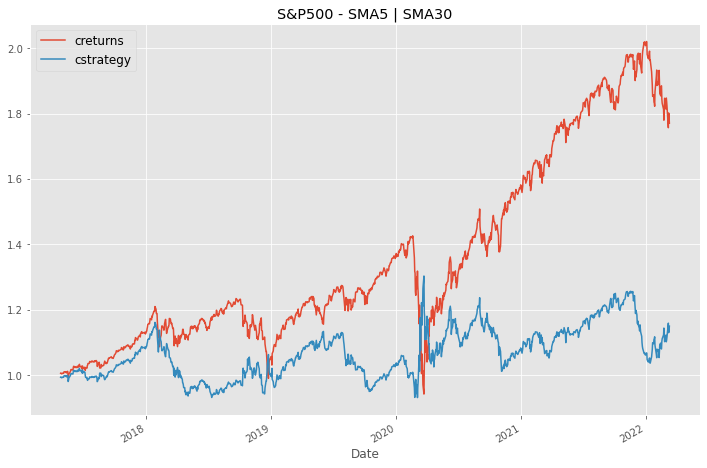

In [1614]:
df[['creturns', 'cstrategy']].plot(figsize = (12, 8), title = 'S&P500 - SMA{} | SMA{}'.format(sma1, sma2))
plt.legend(fontsize = 12);

In [1615]:
outperf = df['cstrategy'].iloc[-1] - df['creturns'].iloc[-1]
outperf

-0.6209188513323567

In [1616]:
df_2 = df.loc['2021':,:].copy()
df_2['creturns'] = df_2['returns'].cumsum().apply(np.exp)
df_2['cstrategy'] = df_2['strategy'].cumsum().apply(np.exp)
df_2

Symbols,S&P500,sma_s,sma_l,position,returns,strategy,creturns,cstrategy
Date,,,,,,,,
2021-01-04,3700.649902,3730.232031,3674.650342,1,-0.014865,-0.014865,0.985245,0.985245
2021-01-05,3726.860107,3728.532031,3679.483341,1,0.007058,0.007058,0.992223,0.992223
2021-01-06,3748.139893,3732.752002,3685.836670,1,0.005694,0.005694,0.997889,0.997889
2021-01-07,3803.790039,3747.102002,3693.376668,1,0.014738,0.014738,1.012705,1.012705
2021-01-08,3824.679932,3760.823975,3699.685669,1,0.005477,0.005477,1.018266,1.018266
...,...,...,...,...,...,...,...,...
2022-03-07,4201.089844,4317.250000,4408.676644,-1,-0.029963,0.029963,1.118480,1.062228
2022-03-08,4170.700195,4290.138086,4400.695654,-1,-0.007260,0.007260,1.110389,1.069968
2022-03-09,4277.879883,4268.406055,4398.076644,-1,0.025374,-0.025374,1.138924,1.043161


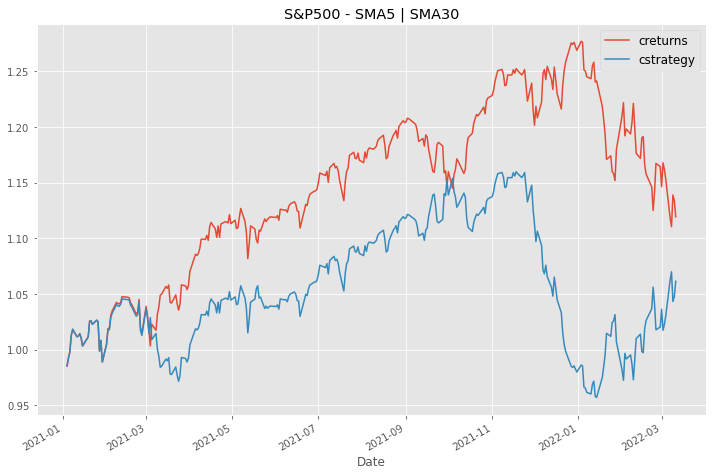

In [1617]:
df_2[['creturns', 'cstrategy']].plot(figsize = (12, 8), title = 'S&P500 - SMA{} | SMA{}'.format(sma1, sma2))
plt.legend(fontsize = 12);

In [1618]:
outperf_2 = df_2['cstrategy'].iloc[-1] - df_2['creturns'].iloc[-1]
outperf_2

-0.05792263324303759

As we can see from the results above, the strategy underperformance is highly dependent on when it starts to be implemented. The total underpefromance went down from -62% to -5.8%. The difference is quite large. One of the main reason for such divergence is the COVID crisis. Right in the worst moment of the crisis, the strategy actually outperfrom largely the market but then, the strategy failed to participate in the bullish trend that followed for the recent years. Let us try now to find the optimal period to implement this strategy to see if we can find one that outperfroms the market.

##### Optimal SMA Strategy

Here, we define a function that runs a SMA strategy for a specified couple of periods. The long and short period. We will then run this in a loop for different periods to see which period actually yields the best perfromance.

In [1528]:
# We define the function that runs the function
def run_strategy(SMA):
    df = etf_data[etf_data_col[[0]]].copy()
    df.columns=df.columns.droplevel()
    df.dropna(inplace=True)
    df['returns'] = np.log(df['S&P500'] / df['S&P500'].shift(1))
    df['sma_s'] = df['S&P500'].rolling(window = int(SMA[0])).mean()
    df['sma_l'] = df['S&P500'].rolling(window = int(SMA[1])).mean()
    df.dropna(inplace = True)
    
    df['position'] = np.where(df['sma_s'] > df['sma_l'], 1, -1)
    df['strategy'] = df['position'].shift(1) * df['returns']
    df.dropna(inplace = True)
    
    return df[['returns', 'strategy']].sum().apply(np.exp)

In [1529]:
run_strategy((25, 75))

Symbols
returns     1.737764
strategy    1.277456
dtype: float64

In [1530]:
run_strategy((10, 50))

Symbols
returns     1.756172
strategy    1.244690
dtype: float64

In [1531]:
run_strategy((22, 252))

Symbols
returns     1.510701
strategy    0.938833
dtype: float64

##### Find the Optimal Windows for the SMA Strategy

Let us run the loop along a range of different options for the short and and the long period. We will try a range from 5 to 50 days for the short leg and from 55 to 200 days for the long leg. 

In [1532]:
from itertools import product

In [1533]:
sma_1 = range(5, 50, 1)
sma_2 = range(55, 200, 1)

In [1534]:
results = pd.DataFrame()

for SMA_1, SMA_2 in product(sma_1, sma_2):
    df = etf_data[etf_data_col[[0]]].copy()
    df.columns=df.columns.droplevel()
    df.dropna(inplace=True)
    df['returns'] = np.log(df['S&P500'] / df['S&P500'].shift(1))
    df['sma_s'] = df['S&P500'].rolling(window = int(SMA_1)).mean()
    df['sma_l'] = df['S&P500'].rolling(window = int(SMA_2)).mean()
    df.dropna(inplace = True)
    
    df['position'] = np.where(df['sma_s'] > df['sma_l'], 1, -1)
    df['strategy'] = df['position'].shift(1) * df['returns']
    df.dropna(inplace = True)
    
    perf = df[['returns', 'strategy']].sum().apply(np.exp)
    
    results = results.append(pd.DataFrame({
        'SMA_1': SMA_1, 'SMA_2': SMA_2, 
        'MARKET' : perf['returns'], 
        'STRATEGY' : perf['strategy'], 
        'OUT' : perf['strategy'] - perf['returns']
    }, index = [0]), ignore_index = True)

results

,SMA_1,SMA_2,MARKET,STRATEGY,OUT
0,5,55,1.742423,1.220028,-0.522396
1,5,56,1.743225,1.229324,-0.513901
2,5,57,1.730126,1.258354,-0.471772
3,5,58,1.723735,1.321217,-0.402518
4,5,59,1.725836,1.308202,-0.417634
...,...,...,...,...,...
6520,49,195,1.571229,0.924112,-0.647117
6521,49,196,1.562848,0.908837,-0.654011
6522,49,197,1.567912,0.911782,-0.656130
6523,49,198,1.569212,0.912538,-0.656674


In [1535]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6525 entries, 0 to 6524
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA_1     6525 non-null   int64  
 1   SMA_2     6525 non-null   int64  
 2   MARKET    6525 non-null   float64
 3   STRATEGY  6525 non-null   float64
 4   OUT       6525 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 255.0 KB


In [1536]:
results.sort_values('OUT', ascending = False).head(10)

,SMA_1,SMA_2,MARKET,STRATEGY,OUT
1607,16,67,1.728419,1.851148,0.122729
486,8,106,1.724343,1.836611,0.112268
653,9,128,1.684095,1.766681,0.082586
1891,18,61,1.727936,1.808313,0.080377
1751,17,66,1.724548,1.800444,0.075896
485,8,105,1.699384,1.770464,0.071080
1606,16,66,1.724548,1.792924,0.068376
650,9,125,1.705533,1.772554,0.067021
651,9,126,1.708076,1.773915,0.065839
652,9,127,1.689760,1.754893,0.065133


In [1537]:
run_strategy((16, 67))

Symbols
returns     1.728419
strategy    1.851148
dtype: float64

As we can see, the optimal strategy comprise a period of 16 days for the short window moving average and of 67 days for the long window moving average. Nonetheless, as we have seen so far, this strategy is hihgly dependent on the timeframe chosen and the optimal window might change throught time. An interesting improvement to such strategy could have been to compute each day the optimal window for both, the short and long window. 

Aditionally, other strategies aimed to derive market signals from data could have been used to compare against our results. Some examples are the Exponential Movin Average Strategy, the Absolute Price Oscillator, Moving Average Convergende Divergence, etc. 

 As an alternative to the SMAs strategy, we will explore a machine learning method that can allow us to predict changes in market tendencys. Just as before, the model will send signals whenever a change in market is expected. In other words, we will train the model to predict if the next day price movement will be upwards or donwards and then trade consenquently.

#### SVM

As we briefly explained above, the Support Vector Machine si a machine model that is based on clustering the data into different classes. Data is plotted in a n-dimansion space and then the model finds the hyperplane that maximized the distance between each classes to that hyperplane. In this case, our label will be the market direction and the features will be the same features we used to predict the S&P500 returs. First, we need to prepare our data.

For this we will create our signal. Which basically says that when the return from tomorrow is higher than today's return, you should go long, short otherwise. Then we will pass the signal as a label to our SVM model and we wiil train to so that with the information possessed today you can predict the signal, which has tomorrow's return information embedded. 

One important thing to take into account is that we will be creating the singal on a series of returns that was already shifted one day back. So, we need to do a shift one day ahead when comparing the returns in order to be comparing today's return (the series that has been shift one day ahead) to the returns observed tomorrow (the returns that was originally shifted one day ahead). This is important when creating the singal as we will se in the code below.

In [1538]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from pandas_datareader import data

In [1558]:
Y_s = etf_data.loc[Y_1.index,:][('Adj Close','S&P500')]

In [1559]:
# Here, we define the function to create the trade signal by comparing today's return to tomorrow's return
# The function will return both a dataframe with the features and the labels. The labels correspond to the signal 
# to be applied tomorrow, which was predicted with today feature's observations
def create_trading_condition(df):
    X_d = X
    Y_d = np.where(df.shift(1) > df, -1, 1) #  In out data frame the return at each row is the return observed the day after the row's specific date
                                            #  So, df.shift(1) has the return that actually corresponds to the date stated above.
    return(X_d, Y_d)
# Here, we create the function to create the train and data set
def create_train_split_group(X_f, Y_f, val_size = 0.9):
    train_size = int(len(X_f) * (1-val_size))
    x_train_i, x_test_i = X_f[0:train_size], X_f[train_size:len(X_f)]
    y_train_i, y_test_i = Y_f[0:train_size], Y_f[train_size:len(X_f)]
    return x_train_i, x_test_i, y_train_i, y_test_i

X_d, Y_d = create_trading_condition(Y_s) 

X_train, X_test, Y_train, Y_test = create_train_split_group(X, Y_d)
Y_train


array([ 1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1, -1,
        1,  1, -1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1,
        1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1,
       -1,  1,  1,  1, -1,  1, -1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1])

In [1560]:
# Here, we fit the model 
svc = SVC()
svc.fit(X_train, Y_train)

# We create a new data frame to store the predicted signal
Y_d_p = Y_d.copy()

# We predcit the singal to be applied in our strategy
Y_d_p= pd.DataFrame(svc.predict(X))
Y_d_p.columns=['Predicted_Signal']
Y_d_p.index=Y_1.index
Y_d_p['Returns S&P500'] = Y_1.copy()
Y_d_p


,Predicted_Signal,Returns S&P500
2018-03-12,-1,-0.006384
2018-03-13,-1,-0.005741
2018-03-14,-1,-0.000782
2018-03-15,1,0.001702
2018-03-16,1,-0.014306
...,...,...
2022-03-04,-1,-0.029963
2022-03-07,-1,-0.007260
2022-03-08,1,0.025374
2022-03-09,-1,-0.004301


Now that we have predicted at each day the signal to be applied tomorrow, we will implement a strategy based on such signals. The signal indicates wether to go long and short the underlying asset, which in this case is the S&P500.

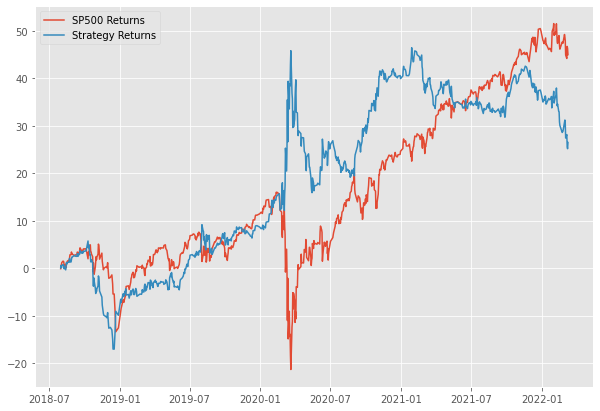

In [1619]:
# With this function we compute the accumulated real return and we compute the return of the strategy at each day
def calculate_return(df, split_value):
    cum_SP500_return = df[split_value: ]['Returns S&P500'].cumsum() * 100
    df["Strategy_Returns"] = df['Returns S&P500'] * df["Predicted_Signal"].shift(1)
    return cum_SP500_return

# Then, we define a function to copute the accumulated return corresponding to the strategy
def calculate_strategy_return(df, split_value):
    cum_strategy_return = df[split_value: ]["Strategy_Returns"].cumsum() * 100
    return cum_strategy_return

# Here, we apply the function to cumpute both, the S&P500 and the strategy, accumulated returns
cum_SP500_return = calculate_return(Y_d_p, split_value = len(X_train))
cum_strategy_return = calculate_strategy_return(Y_d_p, split_value = len(X_train))

# Here, we define a function to create a plot of the acummulated returns to compare a only long strategy and the onbased on the predicted singals
def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize = (10, 7))
    plt.plot(cum_symbol_return, label = "%s Returns" % symbol)
    plt.plot(cum_strategy_return, label = "Strategy Returns")
    plt.legend()
    plt.show()
    
plot_chart(cum_SP500_return, cum_strategy_return, symbol = "SP500")


In [1571]:
def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()

In [1572]:
accuracy_train = accuracy_score(Y_train, svc.predict(X_train))
accuracy_test = accuracy_score(Y_test, svc.predict(X_test))
print(accuracy_train, accuracy_test)
print(sharpe_ratio(cum_SP500_return,cum_strategy_return))

0.8928571428571429 0.7814136125654451
0.17766474457164827


As we can see above, the strategy based on the predicted signal clearly outperfroms on some periods along only strategy. Aditionally, when we compute the sharpe ratio for the strategy, we can see that the excess return slightly compensate for the volatility of the strategy as it is below one. Although, it is important to note that the SVM does do good a job in predicting the next day signal when a large downturn is ahead.

Finally, let us try to implement the strategy proposed at the beginning at this excerscise. We will take the predicted singal to perfrom our trades but instead of shorting the S&P500, we will hedge our exposure by trading the VIXY ETF. First, we will prepare the data to compute the returns for this strategy.

In [1573]:
# Here, we create a new dataframe with the data not used to train our model and to which we will implement our strategy 
strategy_fin_d = Y_d_p.iloc[:,0:2].loc[y_test_2.index,:]
strategy_fin_d

,Predicted_Signal,Returns S&P500
2021-10-14,1,0.007433
2021-10-15,1,0.003369
2021-10-18,1,0.007366
2021-10-19,1,0.003657
2021-10-20,1,0.002991
...,...,...
2022-03-04,-1,-0.029963
2022-03-07,-1,-0.007260
2022-03-08,1,0.025374
2022-03-09,-1,-0.004301


In [1574]:
# Here, we add to our dataframe the predicted tomorrow's return 
strategy_fin = pd.concat([strategy_fin_d,pd.DataFrame(y_test_2,index=y_test_2.index),pd.DataFrame(predictions_1,index=y_test_2.index),pd.DataFrame(predictions_2,index=y_test_2.index)], join = "inner", axis=1)
# We rename the columns
strategy_fin.columns=['Predicted_Signal','Returns S&P500','Returns VIXY','Pred S&P500','Pred VIXY']
# We compute the hedging return based on our predicted reutnrs
# The predicted hedge ratio will be computed in absolute values as the sign of is implicit in the predicted sing
strategy_fin['Pred_Hedge_Ratio']= np.abs(strategy_fin['Pred S&P500']/strategy_fin['Pred VIXY'])
strategy_fin

,Predicted_Signal,Returns S&P500,Returns VIXY,Pred S&P500,Pred VIXY,Pred_Hedge_Ratio
2021-10-14,1,0.007433,-0.000536,0.001139,0.000677,1.681720
2021-10-15,1,0.003369,-0.020575,-0.001718,-0.013533,0.126938
2021-10-18,1,0.007366,-0.009343,0.004672,-0.018300,0.255319
2021-10-19,1,0.003657,-0.008317,0.000519,-0.037249,0.013935
2021-10-20,1,0.002991,-0.033402,0.002554,-0.036608,0.069759
...,...,...,...,...,...,...
2022-03-04,-1,-0.029963,0.084823,0.010396,0.003343,3.110029
2022-03-07,-1,-0.007260,-0.009946,0.004442,-0.036773,0.120796
2022-03-08,1,0.025374,-0.041710,-0.001110,-0.040282,0.027563
2022-03-09,-1,-0.004301,-0.044472,-0.016336,-0.028754,0.568135


In [1575]:
# In this step, we shift both the predicted signal and the predicted hedge ratio, as they are predicted on each day's market information
# but they are intended to be applied one day ahead
strategy_fin_2=strategy_fin.copy()
strategy_fin_2['Predicted_Signal']=strategy_fin['Predicted_Signal'].shift(1)
strategy_fin_2['Pred_Hedge_Ratio']=strategy_fin['Pred_Hedge_Ratio'].shift(1)
strategy_fin_2.dropna()

,Predicted_Signal,Returns S&P500,Returns VIXY,Pred S&P500,Pred VIXY,Pred_Hedge_Ratio
2021-10-15,1.0,0.003369,-0.020575,-0.001718,-0.013533,1.681720
2021-10-18,1.0,0.007366,-0.009343,0.004672,-0.018300,0.126938
2021-10-19,1.0,0.003657,-0.008317,0.000519,-0.037249,0.255319
2021-10-20,1.0,0.002991,-0.033402,0.002554,-0.036608,0.013935
2021-10-21,1.0,-0.001073,0.019949,0.007147,-0.055874,0.069759
...,...,...,...,...,...,...
2022-03-04,1.0,-0.029963,0.084823,0.010396,0.003343,0.046298
2022-03-07,-1.0,-0.007260,-0.009946,0.004442,-0.036773,3.110029
2022-03-08,-1.0,0.025374,-0.041710,-0.001110,-0.040282,0.120796
2022-03-09,1.0,-0.004301,-0.044472,-0.016336,-0.028754,0.027563


As the final step, we will implement the strategy but we will set a restriction regarding the hedge ratio. As we saw at the begining in this coursework, the rolling correlation between the VIXY and the S&P500 varies a lot throughout time but it alwasys stays between -0.5 and -1.0. So, whenever the predicted hedge ratio is lower than 0.5 and a hedge is to be implemented, the hedge ratio will be set to be 0.5.

In [1620]:
k=0
for i in strategy_fin_2.index:
    if strategy_fin_2.loc[i,'Predicted_Signal']<0:
        if strategy_fin_2.loc[i,'Pred_Hedge_Ratio']<0.5:
            strategy_fin_2.loc[i,'Strategy Return']= 0.5*strategy_fin_2.loc[i,'Returns VIXY']+strategy_fin_2.loc[i,'Returns S&P500']
        else:
            strategy_fin_2.loc[i,'Strategy Return']= strategy_fin_2.loc[i,'Pred_Hedge_Ratio']*strategy_fin_2.loc[i,'Returns VIXY']+strategy_fin_2.loc[i,'Returns S&P500']
    else:
        strategy_fin_2.loc[i,'Strategy Return']=strategy_fin_2.loc[i,'Returns S&P500']
    k+=1


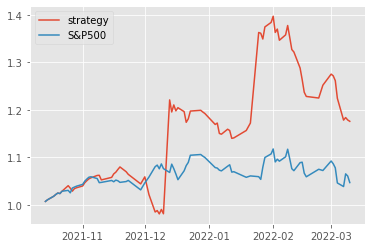

In [1621]:
plt.plot(pd.DataFrame(strategy_fin_2.loc[:,'Strategy Return']).cumsum().apply(np.exp), label='strategy')
plt.plot(pd.DataFrame(strategy_fin_2.loc[:,'Returns S&P500']).cumsum().apply(np.exp), label='S&P500')
plt.legend()
plt.show()


In [1622]:
print(sharpe_ratio(strategy_fin_2.loc[:,'Returns S&P500'],strategy_fin_2.loc[:,'Strategy Return']))

0.04308462929138581


As we can see in the graph above, the strategy succeeds in outperforming the market return and has even a positive sharpe ratio. Nonetheless, it is mainly due to two days in which the implemented hedge was hihgly leveraged. Near the end of the period, we can observe that an incorrect predicted signal was quite expensive for the strategy. Next, we will implement a final constraint regarding the leverage you can implement when engaging into the hedge. The limit will be set at 2.5x as we believe that a larger leverage ratio will be hardly implemented.

In [1623]:
k=0
for i in strategy_fin_2.index:
    if strategy_fin_2.loc[i,'Predicted_Signal']<0:
        if strategy_fin_2.loc[i,'Pred_Hedge_Ratio']<0.5:
            strategy_fin_2.loc[i,'Strategy Return']= 0.5*strategy_fin_2.loc[i,'Returns VIXY']+strategy_fin_2.loc[i,'Returns S&P500']
        elif strategy_fin_2.loc[i,'Pred_Hedge_Ratio']>2.5:
            strategy_fin_2.loc[i,'Strategy Return']= 2.5*strategy_fin_2.loc[i,'Returns VIXY']+strategy_fin_2.loc[i,'Returns S&P500']
        else:
            strategy_fin_2.loc[i,'Strategy Return']= strategy_fin_2.loc[i,'Pred_Hedge_Ratio']*strategy_fin_2.loc[i,'Returns VIXY']+strategy_fin_2.loc[i,'Returns S&P500']
    else:
        strategy_fin_2.loc[i,'Strategy Return']=strategy_fin_2.loc[i,'Returns S&P500']
    k+=1


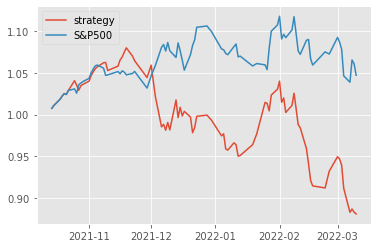

In [1624]:
plt.plot(pd.DataFrame(strategy_fin_2.loc[:,'Strategy Return']).cumsum().apply(np.exp), label='strategy')
plt.plot(pd.DataFrame(strategy_fin_2.loc[:,'Returns S&P500']).cumsum().apply(np.exp), label='S&P500')
plt.legend()
plt.show()


In [1586]:
print(sharpe_ratio(strategy_fin_2.loc[:,'Returns S&P500'],strategy_fin_2.loc[:,'Strategy Return']))

-0.14530029839773584


As we can see above, the cap on how much we can leverage the hedge has an important effect. It turns the strategy into a not profitable strategy and the sharpe ratio goes into negative territory. 

#### Conclusion

As we saw during all the analysis done in this workbook, there are several improvements that could be done in constructing this strategy. This improvements might be time consuming and we decided to stick to the results obtained to show that even with the errors and problems spotted here, the overall strategy seems to be profitable. Further improvemens can be predicting returns using a Recursive Neural Network as it allows to keep long and short term memory within the model. Volatility can be modeled throuhg modeles like GARCH or EWMA which has been shown in the literatre that work prety well. The hede ratio could be tried to be modeled also using RNN. Finally, other machine learngin classification models could be implemented to predict trading singals based on the rule stated above. 

Another important feature of the strategy implemented that needs to be taken into account is that it might be highly dependent on the time period considered both when fitting the model and when testing its perfromance. This can be avoid by predicting always only one day ahead and then incorporating each day the new observed information. Nontheless, one should be sure to not fall into model overfitting. 

The strategy seems to work as, whenever market turmoil comes, the aggressive hedge is very profitable. So, even if in most of the periods the strategy dosen't seems work that well given all the errors observed in both, the hedge ratio and the market signal, predictions, as long as the strategy is able to foreseen large market movements and assume high leverage ratios it turns out to be profitable overall. Nevertheless, more consistent forecast models needs to be implemented in order to construct a strategy that might work over time. Nevertheless, one thing that should be clear is that the VIXY ETF is a strong contendet to hedge market risk as it allows to overhedge and implement an "agressinve hedge" in a somewhat more easy way as no margin administration needs to be implemented.